<a href="https://colab.research.google.com/github/macapagithub/pythorch-hugging-face/blob/main/2.1.RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

### Dataset
Cargamos el dataset seleccionado, en este caso vamos a usar [Blidness dataset](https://www.kaggle.com/c/aptos2019-blindness-detection). Enlace: https://drive.google.com/file/d/17tBPk50MncNdxms5T23VbPiFzlqvpay8/view?usp=sharing. Es un dataset de imagenes de retinas, donde se busca, detectar una posible ceguera antes de que suceda.

In [5]:
%%capture
!wget  https://drive.google.com/file/d/17tBPk50MncNdxms5T23VbPiFzlqvpay8/view?usp=sharing -O Blidness.zip
!unzip Blidness.zip

Teniendo en cuenta que nuestro conjunto de datos está separado en dos carpetas, train y test, creamos un objeto path para cada una de ellas.

In [6]:
dataset = ImageFolder(root='blindness/train', transform=transform)

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

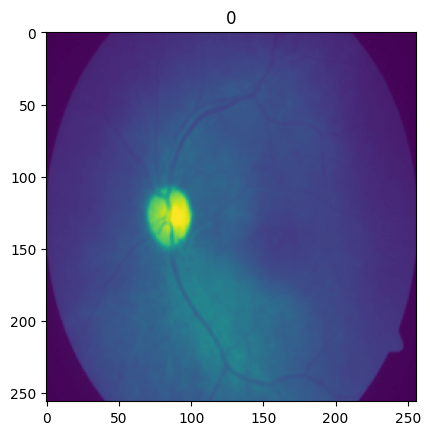

In [10]:
from matplotlib import pyplot as plt

# Visualizar un ejemplo
imagen, etiqueta = train_dataset[0]
plt.imshow(imagen[0])
plt.title(etiqueta)
plt.show()


Descargar el modelo pre-entrenado ResNet18

In [11]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Congelar los parámetros de las capas previamente entrenadas

In [12]:
for param in model.parameters():
    param.requires_grad = False

Reemplazar la capa final (fully connected) para adaptarla a nuestro problema de clasificación


In [13]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

Mover el modelo al dispositivo de hardware adecuado (CPU o GPU)

In [14]:
model = model.to(device)

Definir la función de pérdida y el optimizador

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            epoch_accuracy = correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), 'best_model_resnet18.pth')
        scheduler.step(epoch_accuracy)

In [17]:
# Entrenar el modelo
train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch [1/10], Loss: 1.3627, Accuracy: 0.6273
Epoch [2/10], Loss: 1.0166, Accuracy: 0.6982
Epoch [3/10], Loss: 0.8723, Accuracy: 0.7055
Epoch [4/10], Loss: 0.7946, Accuracy: 0.7236
Epoch [5/10], Loss: 0.7457, Accuracy: 0.7236
Epoch [6/10], Loss: 0.7121, Accuracy: 0.7291
Epoch [7/10], Loss: 0.6815, Accuracy: 0.7455
Epoch [8/10], Loss: 0.6639, Accuracy: 0.7582
Epoch [9/10], Loss: 0.6453, Accuracy: 0.7418
Epoch [10/10], Loss: 0.6234, Accuracy: 0.7473


Evaluar el modelo en el conjunto de test (código para cargar y evaluar el conjunto de test)

In [ ]:
model.load_state_dict(torch.load('best_model_resnet18.pth'))
model.eval()

<ipython-input-18-1769fe4405fe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_resnet18.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Descargar y cargar el conjunto de test

In [19]:
test_dataset = ImageFolder(root='blindness/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Evaluar el modelo en el conjunto de test

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print('Test Accuracy: {:.4f}'.format(test_accuracy))

Test Accuracy: 0.7656


Model Hub

In [21]:
pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

In [22]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `PytHug` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pu

Otra manera de hacer loging es con:

notebook_login()

In [26]:
from huggingface_hub import HfApi, HfFolder, Repository

api = HfApi()
repo_name = 'macapa/blindness_clas'
# repo_url = api.create_repo(repo_id = repo_name)

In [ ]:
api.upload_file(
    path_or_fileobj='/content/best_model_resnet18.pth',
    path_in_repo='best_model_resnet18.pth',
    repo_id = repo_name
)

best_model_resnet18.pth:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/macapa/blindness_clas/commit/be326735add70abe38ded4eddae62e47a1ba8d05', commit_message='Upload best_model_resnet18.pth with huggingface_hub', commit_description='', oid='be326735add70abe38ded4eddae62e47a1ba8d05', pr_url=None, pr_revision=None, pr_num=None)

Cargar modelo

In [27]:
!mkdir new_models

In [28]:
from huggingface_hub import hf_hub_download

hf_hub_download(
    repo_id=repo_name,
    filename='best_model_resnet18.pth',
    local_dir='new_models/'
)

best_model_resnet18.pth:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

'new_models/best_model_resnet18.pth'